## IDs:
ID 1: 204502926 <br>
ID 2: 039065313

## Imports:

In [1]:
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from numpy.linalg import solve

np.random.seed(0)

### Question 1: Data exploration (15 points)

#### Answer:

In [2]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False): 
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=5, bbox={'facecolor':'k', 'pad':5}, color='w')
    ax.set_xlabel(xlab, fontsize=16, labelpad=10)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    plt.xticks(rotation=45)
    plt.hist(dataset[attribute], bins=50, color=bar_color, ec=edge_color, linewidth=2)

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Sparsity: 0.9369533063577546



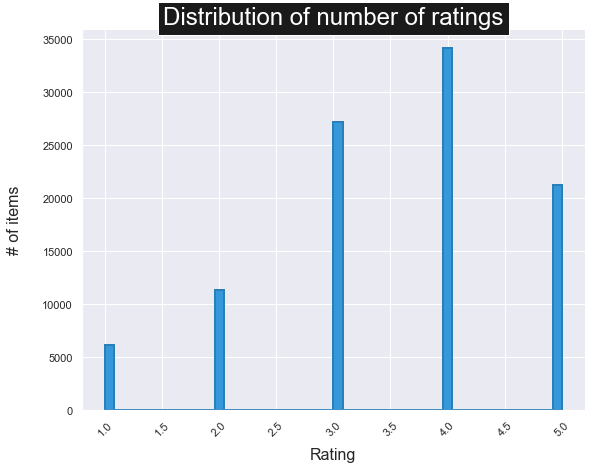

In [161]:
# Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item. 
# Include additional exploration you find relevant to questions 2 and 3.
# Discuss your insights and possible challenges related to the prediction task described in question 2.


# Remember that sparsity is calculated by the number of cells in a matrix that contain a rating divided by the total number of values that matrix could hold given the number of users and items (movies). 
# In other words, dividing the number of ratings present in the matrix by the product of users and movies in the matrix and subtracting that from 1 will give us the sparsity or the percentage of the ratings matrix that is empty.

file_path = 'ml-100k/u.data' # grouplens.org/datasets/movielens/100k

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep='\t', names=names)

print(data.head())

all_users_ids = data.user_id.unique()
all_items_ids = data.item_id.unique()
ratings_count = data.shape[0] # 100,000
users_count = len(all_users_ids)
items_count = len(all_items_ids)
sparsity = 1 - (ratings_count / (users_count * items_count))
print(f'Sparsity: {sparsity}')
print()


make_histogram(data, 'rating', title='Distribution of number of ratings', xlab='Rating', ylab='# of items')

We can see that **'4'** is the dominant rating (34,174 ratings)<br>
The average rating is: $\frac{\sum_{i=1}^n(i * y(i))}{|S|}$, where i is a rating value (1-5), y(i) is the amount of ratings per user/item, and |S| is the size of the dataset (100K).<br>
We can also see that the users are more prone to give a perfect rating ('5') rather than < '3'.

In [4]:
average = sum(data['rating']) / len(data['rating'])
print(f'The average rating is {average}')

The average rating is 3.52986



### Question 2: Matrix factorization model implementation and evaluation (60 points)

#### Answer:

In [5]:
def create_rating_matrix_from_raw_data(df):
    ratings = np.zeros((all_users_ids.shape[0], all_items_ids.shape[0]))

    for row in df.itertuples():
        ratings[row[1]-1][row[2]-1] = row[3]  
        
    return ratings

In [6]:
ratings = create_rating_matrix_from_raw_data(data)
# ratings.shape

In [181]:
def get_5_folds(folds_dir='./ml-100k/'):
    number_of_folds = 5
    header = ['user_id', 'item_id', 'rating', 'timestamp']
    folds = []
    
    for i in range(number_of_folds):     
        print(f'{folds_dir}u{i+1}.base')
        
        df_train = pd.read_csv(f'{folds_dir}u{i+1}.base', sep='\t', names=header)
        df_test = pd.read_csv(f'{folds_dir}u{i+1}.test', sep='\t', names=header)   
        
        rating_train = create_rating_matrix_from_raw_data(df_train)
        rating_test  = create_rating_matrix_from_raw_data(df_test)        
           
        folds.append((rating_train, rating_test))
        
    return folds


folds = get_5_folds()

for fold in folds:
    print(fold[0].shape, fold[1].shape)

./ml-100k/u1.base
./ml-100k/u2.base
./ml-100k/u3.base
./ml-100k/u4.base
./ml-100k/u5.base
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)


In [180]:
import math

# MAX_COLUMNS_CUTOFF: (int)
#      A value of 5 or 10 for this exercise.
#      The top n items to check for relevancy.
MAX_COLUMNS_CUTOFF = 5 # or 10

# RATING_THRESHOLD_VALUE: (int)
#      A value between 0-5 (inclusive).
#      The minimal value to indicate that both our prediction and the actual rating recommend an item.
#      Below that, either the user finds this item relevant and we predicted he wouldn't, or the other way around.
RATING_THRESHOLD_VALUE = 3


def get_rmse(pred, actual):
    # Ignore nonzero terms
    squared_error_matrix = (pred - actual)**2
    result = np.sqrt(squared_error_matrix.mean())
    return result


def get_mrr(pred, actual):    
    """
    Mean Reciprocal Rank
    
    Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    matrix = get_relevant_item_matches_matrix_per_user(pred, actual)
    matrix = (np.asarray(r).nonzero()[0] for r in matrix)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in matrix])


def sort_user_ratings(row):
    '''Find the indices of the maximal values in given array'''
    return row.argsort()[-5:][::-1]


def get_relevant_item_matches_matrix_per_user(pred_matrix, actual_matrix):
    top_values_indices = np.apply_along_axis(sort_user_ratings, 1, actual_matrix)
    result = np.zeros_like(top_values_indices)
    rows = len(top_values_indices)
    columns = np.minimum(len(top_values_indices[0]), MAX_COLUMNS_CUTOFF)
    
    for i in range(rows):
        for j in range(columns):
            match = actual_matrix[i][top_values_indices[i][j]] >= RATING_THRESHOLD_VALUE and pred_matrix[i][top_values_indices[i][j]] >= RATING_THRESHOLD_VALUE

            if match:
                result[i][j] = 1
                break

    return result


def discountedCumulativeGain(result):
    dcg = []
    
    for idx, val in enumerate(result): 
        numerator = val
        
        if idx == 0:
            denominator = 1
        else:
            # add 2 because python 0-index
            denominator = np.log2(idx + 2) 
        
        score = numerator/denominator
        dcg.append(score)

    return sum(dcg)


def normalizedDiscountedCumulativeGain(result, sorted_result): 
    dcg = discountedCumulativeGain(result)
    idcg = discountedCumulativeGain(sorted_result)
    ndcg = dcg / idcg
    return ndcg


def get_ndcg(pred, actual):
    '''
    Discounted Cumulative Gain evaluation method
    en.wikipedia.org/wiki/Discounted_cumulative_gain
    '''
    size_of_users = len(actual)
    total = 0
    
    for i in range(size_of_users):
        total += normalizedDiscountedCumulativeGain(pred[i], sorted(actual[i],reverse=True))/size_of_users
    return total


def discountedCumulativeGain(result):
    dcg = []
    
    for idx, val in enumerate(result): 
        numerator = val
        # add 2 because python 0-index
        denominator =  np.log2(idx + 2) 
#         print(f'numerator:{numerator}, denominator:{denominator}, res:{numerator/denominator}')
        score = numerator/denominator
        dcg.append(score)
    
    return sum(dcg)


def normalizedDiscountedCumulativeGain(result, sorted_result): 
    dcg = discountedCumulativeGain(result)
    idcg = discountedCumulativeGain(sorted_result)
    ndcg = dcg / idcg
    return ndcg


# actual = np.array([
# #     [1,1,2,2,4],
#     [1,1,2,2,4]
# ])

# pred = np.array([
# #     [1,1,2,2,4],
#     [0.6,1.29,1.99,2.69,3.4]
# ])

# get_rmse(pred, actual)

0.4648225467853297

In [134]:
MAX_RATING_VALUE = 5
np.random.randint(MAX_RATING_VALUE + 1, size=(2, 4)).astype(float)

array([[3., 1., 5., 3.],
       [3., 0., 2., 0.]])

In [10]:
class ExplicitMFSGD():
    def __init__(self, 
                 ratings,
                 k = 40,
                 item_fact_reg = 0.0, 
                 user_fact_reg = 0.0,
                 item_bias_reg = 0.0,
                 user_bias_reg = 0.0,
                 verbose = False,
                 is_bias_only=False):
        """
        Train a matrix factorization model to predict empty entries in a matrix. 
        The terminology assumes a ratings matrix which is ~ user x item.
        
        (To avoid overfitting we use regularization)

        Params
        ======
        ratings: (ndarray)
            User x Item matrix with corresponding ratings
        
        k_factors: (int)
            Number of latent factors to use in matrix factorization model
        
        item_fact_reg: (float)
            Regularization term for item latent factors
            
        user_fact_reg: (float)
            Regularization term for user latent factors
            
        item_bias_reg: (float)
            Regularization term for item biases
        
        user_bias_reg: (float)
            Regularization term for user biases
        
        verbose: (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.users_count = users_count
        self.items_count = items_count
        self.k_factors = k
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        self._v = verbose
        self.is_bias_only = is_bias_only
        self.curr_iter = 1
        self.user_vecs, self.item_vecs = None, None

    def calculate_learning_curve(self, iter_array, test, learning_rate, evaluate=True):
        self.init_for_train(learning_rate)
        training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg = [], [], [], [], [], []
        predictions_list = []

        if not evaluate:
            predictions_list = [None]*len(iter_array)
        
        for idx, n_iter in enumerate(iter_array):
            if self.is_bias_only:
                self.print_verbose(f'Bias-only model')
            
            self.print_verbose(f'k={self.k_factors}, alpha={learning_rate}, '\
                              f'iterations={n_iter}, item_fact_reg={self.item_fact_reg}, '\
                              f'user_fact_reg={self.user_fact_reg}, item_bias_reg={self.item_bias_reg}, '\
                              f'user_bias_reg={self.user_bias_reg}')
            self.train(n_iter)
            predictions = self.get_prediction_matrix()
            
            if not evaluate:
                predictions_list[idx] = predictions_list                
            else:
                self.evaluate(predictions, test, training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg)

        return predictions_list, training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg
    
    
#     def init_for_train(self, learning_rate=0.1):        
#         # initialize latent vectors
#         # Approximate rating matrix by product of lower rank matrix
#         self.user_vecs = np.random.randint(MAX_RATING_VALUE + 1, size=(self.users_count, self.k_factors)).astype(float)
#         self.item_vecs = np.random.randint(MAX_RATING_VALUE + 1, size=(self.items_count, self.k_factors)).astype(float)
# #         self.item_vecs = np.random.random((self.items_count, self.k_factors))
        
#         self.learning_rate = learning_rate
#         self.user_bias = np.zeros(self.users_count)
#         self.item_bias = np.zeros(self.items_count)
#         self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
    def init_for_train(self, learning_rate=0.1):        
        # initialize latent vectors
        # Approximate rating matrix by product of lower rank matrix
        self.user_vecs = np.random.normal(scale=1./self.k_factors, size=(self.users_count, self.k_factors))
        self.item_vecs = np.random.normal(scale=1./self.k_factors, size=(self.items_count, self.k_factors))
        
        self.learning_rate = learning_rate
        self.user_bias = np.zeros(self.users_count)
        self.item_bias = np.zeros(self.items_count)
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        
    def train(self, n_iter):
        """ 
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        while self.curr_iter <= n_iter:
            if self.curr_iter % 10 == 0 and n_iter > 10 and self._v:
                print(f'\tStill running...')
                print(f'\tCurrent iteration: {self.curr_iter}')
                
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            self.perform_sgd()
            self.curr_iter += 1
            
    def predict(self, user, item):
        """
        Single user and item prediction
        """
        biases = self.global_bias + self.user_bias[user] + self.item_bias[item]
        prediction_value = biases

        if not self.is_bias_only: # bias-only model
            prediction_value += self.user_vecs[user, :].dot(self.item_vecs[item, :].T)
        
        return prediction_value
    
    def perform_sgd(self):
        for idx in self.training_indices:
            user = self.sample_row[idx]
            item = self.sample_col[idx]
            prediction = self.predict(user, item)
            actual_rating = self.ratings[user, item] # get actual rating from the dataset's ratings array 
            error = actual_rating - prediction
            
            # Update biases
            self.user_bias[user] += (self.learning_rate * (error - self.user_bias_reg * self.user_bias[user]))
            self.item_bias[item] += (self.learning_rate * (error - self.item_bias_reg * self.item_bias[item]))
            
            # Update latent factors
            self.user_vecs[user, :] += self.learning_rate * (error * self.item_vecs[item, :] - self.user_fact_reg * self.user_vecs[user,:])
            self.item_vecs[item, :] += self.learning_rate * (error * self.user_vecs[user, :] - self.item_fact_reg * self.item_vecs[item,:])
    
    def get_prediction_matrix(self):
        """
        Predict ratings for every user and item
        """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        
        for user in range(self.user_vecs.shape[0]):
            for item in range(self.item_vecs.shape[0]):
                predictions[user, item] = self.predict(user, item)
                
        return predictions
    
    def evaluate(self, predictions, test, training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg):
        training_rmse.append(get_rmse(predictions, self.ratings))
        test_rmse.append(get_rmse(predictions, test))

        training_mrr.append(get_mrr(predictions, self.ratings))
        test_mrr.append(get_mrr(predictions, test))

        training_ndcg.append(get_ndcg(predictions, self.ratings))
        test_ndcg.append(get_ndcg(predictions, test))
        
        self.print_verbose(f'Training RMSE = {training_rmse[-1]}')
        self.print_verbose(f'Test RMSE = {test_rmse[-1]}')
        
        self.print_verbose(f'Training MRR = {training_mrr[-1]}')
        self.print_verbose(f'Test MRR = {test_mrr[-1]}')

        self.print_verbose(f'Training NDCG = {training_ndcg[-1]}')
        self.print_verbose(f'Test NDCG = {test_ndcg[-1]}')

    def print_verbose(self, msg):
        if self._v:
            print(msg)

In [11]:
class ExplicitMFALS:
    def __init__(self,
                 ratings,
                 k=40,
                 item_reg=0.0,
                 user_reg=0.0,
                 verbose=False):
        self.ratings = ratings
        self.users_count = users_count
        self.items_count = items_count        
        self.k_factors = k
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose
        self.curr_iter = 1

    def calculate_learning_curve(self, iter_array, test, evaluate=True):
        self.init_for_train()
        training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg = [], [], [], [], [], []
        predictions_list = []
        
        if not evaluate:
            predictions_list = [None]*len(iter_array)
        
        for idx, n_iter in enumerate(iter_array):
            self.print_verbose(f'k={self.k_factors}, '\
                               f'iterations={n_iter}, '\
                               f'item_reg={self.item_reg}, '\
                               f'user_reg={self.user_reg}')
            self.train(n_iter)
            predictions = self.predict_all()
            
            if not evaluate:
                predictions_list[idx] = predictions
            else:
                self.evaluate(predictions, test, training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg)  
        
        print('============================================')
        
        return predictions_list, training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg
    
    def als_step_user(self):
        YTY = self.item_vecs.T.dot(self.item_vecs)
        lambdaI = np.eye(YTY.shape[0]) * self.user_reg

        for u in range(self.user_vecs.shape[0]):
            self.user_vecs[u, :] = solve((YTY + lambdaI), self.ratings[u, :].dot(self.item_vecs))

    def als_step_item(self):
        XTX = self.user_vecs.T.dot(self.user_vecs)
        lambdaI = np.eye(XTX.shape[0]) * self.item_reg

        for i in range(self.item_vecs.shape[0]):
            self.item_vecs[i, :] = solve((XTX + lambdaI), self.ratings[:, i].T.dot(self.user_vecs))

    def init_for_train(self):
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1. / self.k_factors,
                                          size=(self.users_count, self.k_factors))
        self.item_vecs = np.random.normal(scale=1. / self.k_factors,
                                          size=(self.items_count, self.k_factors))
        print(f'user_vecs: {self.user_vecs.shape}, item_vecs: {self.item_vecs.shape}')

    def train(self, n_iter):
        """ 
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        while self.curr_iter <= n_iter:
            if self.curr_iter % 10 == 0 and n_iter > 10 and self._v:
                print(f'\tStill running...')
                print(f'\tCurrent iteration: {self.curr_iter}')
                
            self.als_step_user()
            self.als_step_item()
            self.curr_iter += 1
            
    def predict(self, u, i):
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)

    def predict_all(self):
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
        return predictions
                       
    def evaluate(self, predictions, test, training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg):
        training_rmse.append(get_rmse(predictions, self.ratings))
        test_rmse.append(get_rmse(predictions, test))

        training_mrr.append(get_mrr(predictions, self.ratings))
        test_mrr.append(get_mrr(predictions, test))

        training_ndcg.append(get_ndcg(predictions, self.ratings))
        test_ndcg.append(get_ndcg(predictions, test))
        
        self.print_verbose(f'Training RMSE = {training_rmse[-1]}')
        self.print_verbose(f'Test RMSE = {test_rmse[-1]}')
        
        self.print_verbose(f'Training MRR = {training_mrr[-1]}')
        self.print_verbose(f'Test MRR = {test_mrr[-1]}')

        self.print_verbose(f'Training NDCG = {training_ndcg[-1]}')
        self.print_verbose(f'Test NDCG = {test_ndcg[-1]}')
        
    def print_verbose(self, msg):
        if self._v:
            print(msg)        

In [12]:
import copy
from itertools import combinations, combinations_with_replacement, permutations

def permutation_regularization_generator(base_dict):
#     regularization_parameters_values = [0.01, 0.1, 1.0]
    regularization_parameters_values = [0.01]
    regularization_permutations = set()
    number_of_regularization_params = len(base_dict)
    
    for seq in list(combinations_with_replacement(regularization_parameters_values, number_of_regularization_params)):
        for perm_seq in permutations(seq, number_of_regularization_params):
            regularization_permutations.add(perm_seq)

    regularization_parameters_dict_list = []      
    keys = base_dict.keys()
    
    for perm in regularization_permutations:
        curr_values_dict = copy.deepcopy(base_dict)
        
        for idx, key in enumerate(keys):
            curr_values_dict[key] = perm[idx]
        
        regularization_parameters_dict_list.append(curr_values_dict)
        
    return regularization_parameters_dict_list

In [13]:
def generate_list_of_regularization_parameters_values(model_type):
    if model_type.lower() == "als":
        base_dict = {'item_reg': 0.0, 'user_reg':0.0}
    else: # model type == "sgd"
        base_dict = {'item_fact_reg': 0.0, 'user_fact_reg': 0.0, 'item_bias_reg': 0.0, 'user_bias_reg':0.0}
        
    return permutation_regularization_generator(base_dict)        

    
def als_model_provider(**params):
    return ExplicitMFALS(**params)


def sgd_model_provider(**params):
    return ExplicitMFSGD(**params)

In [14]:
# CODE EXAMPLE ON HOW I PASSED PARAMS:

def y(a=0, b=1, c=2, d=3):
    print(f'a:{a}, b:{b}, c:{c}, d:{d}')
    
def x(**params):
    y(**params)
    
last_params = {'c': 35, 'd': 45}
x(a=10,b=20,**last_params)   

a:10, b:20, c:35, d:45


In [16]:
def execute_model(model_provider, params_and_results, model_ctor_input, model_input):
    model = model_provider(**model_ctor_input)
    predictions_list, training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg = model.calculate_learning_curve(**model_input)    
    curr_run_params_and_results = {**model_input, **model_ctor_input, "predictions_list": predictions_list, "training_rmse": training_rmse, "test_rmse": test_rmse, "training_mrr": training_mrr, "test_mrr": test_mrr, "training_ndcg": training_ndcg, "test_ndcg": test_ndcg}    
    params_and_results.append(curr_run_params_and_results)    


In [17]:
def calculate_learning_curve(training_data, test_data, model_provider, model_type="sgd", verbose=True, evaluate=True, pickle_file_name=None):
    regularization_parameters_values = generate_list_of_regularization_parameters_values(model_type)    
    perm_count = 1
    params_and_results = []
    
    model_ctor_input = {"ratings": training_data, "verbose": verbose}        
    model_input = {"iter_array": iter_array, "test": test_data, "evaluate": evaluate}
    
    hyper_param_learning_iter_num = len(k_options)*len(regularization_parameters_values)
    if model_type.lower() == "sgd":
        hyper_param_learning_iter_num *= len(learning_rate_options)
        
    if pickle_file_name and not evaluate:
        pickle_file = open(pickle_file_name, 'ab+')
    for k in k_options:
        model_ctor_input["k"] = k
        for regularization_parameters_value in regularization_parameters_values:
            model_ctor_input = {**model_ctor_input, **regularization_parameters_value}
            if model_type.lower() == "als":
                print(f'iteration {perm_count}/{hyper_param_learning_iter_num}')
                execute_model(model_provider, params_and_results, model_ctor_input, model_input)  
                if pickle_file_name and not evaluate:
                    pickle.dump(params_and_results[-1], pickle_file)
                perm_count += 1
            else: # sgd
                for learning_rate in learning_rate_options:
                    print(f'iteration {perm_count}/{hyper_param_learning_iter_num}')
                    model_ctor_input["is_bias_only"] = False
                    model_input["learning_rate"] = learning_rate
                    execute_model(model_provider, params_and_results, model_ctor_input, model_input)  
                    if pickle_file_name and not evaluate:
                        pickle.dump(params_and_results[-1], pickle_file)                    
                    perm_count += 1
                    
    if pickle_file_name and not evaluate:    
        pickle_file.close()
    return params_and_results

In [18]:
def evaluate(predictions_list, test):
    training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg = [], [], [], [], [], []   
    
    for idx, predictions in enumerate(predictions_list):
        print(idx)
        training_rmse.append(get_rmse(predictions, self.ratings))
        test_rmse.append(get_rmse(predictions, test))

        training_mrr.append(get_mrr(predictions, self.ratings))
        test_mrr.append(get_mrr(predictions, test))

        training_ndcg.append(get_ndcg(predictions, self.ratings))
        test_ndcg.append(get_ndcg(predictions, test))
        
        self.print_verbose(f'Training RMSE = {training_rmse[-1]}')
        self.print_verbose(f'Test RMSE = {test_rmse[-1]}')
        
        self.print_verbose(f'Training MRR = {training_mrr[-1]}')
        self.print_verbose(f'Test MRR = {test_mrr[-1]}')

        self.print_verbose(f'Training NDCG = {training_ndcg[-1]}')
        self.print_verbose(f'Test NDCG = {test_ndcg[-1]}')
        
    return training_rmse, test_rmse, training_mrr, test_mrr, training_ndcg, test_ndcg 


def evaluate_als(params_and_results, predictions_list, test):
    for single_params_and_results in params_and_results:
        predictions_list = single_params_and_results["predictions_list"]
        k, item_reg, user_reg = single_params_and_results['k'], single_params_and_results['item_reg'], single_params_and_results['user_reg']
        print(f'Predictions for k:{k}, item_reg:{item_reg}, user_reg: {user_reg}')

        evalute(predictions_list, test)
            
            
def evaluate_sgd(predictions_list, test):
    for single_params_and_results in params_and_results:
        predictions_list = single_params_and_results["predictions_list"]
        k, item_fact_reg, user_fact_reg, item_bias_reg, user_bias_reg = single_params_and_results['k'], single_params_and_results['item_fact_reg'], single_params_and_results['user_fact_reg'], single_params_and_results['item_bias_reg'], single_params_and_results['user_bias_reg']
        print(f'Predictions for k:{k}, item_fact_reg:{item_fact_reg}, user_fact_reg: {user_fact_reg}, item_bias_reg: {item_bias_reg}, user_bias_reg: {user_bias_reg}')
        evalute(predictions_list, test)

In [19]:
# OFFICIAL AND FINAL PARAMETERS FOR SUBMISSION
k_options = [5, 10, 20]
learning_rate_options = [0.001, 0.01, 0.1]
iter_array = [1, 5, 10, 25, 50, 100, 200]

# DEMO AND SMALLER PARAMETERS - NOT FOR SUBMISSION
k_options = [5, 10, 20]
learning_rate_options = [0.001, 0.01]
iter_array = [1, 5, 10, 20]

In [20]:
def get_number_of_permutations_string(model_type="sgd"):
    regularization_parameters_values = generate_list_of_regularization_parameters_values(model_type)
    print(f'Total of {len(regularization_parameters_values)} regularization parameters permutations')

    if model_type.lower() == "als":
        permutations_string = "(|k's| * |reg's|^2)"
        hyper_param_learning_iter_num = len(k_options)*len(regularization_parameters_values)
    else: # sgd
        permutations_string = "(|k's| * |alphas| * |reg's|^4)"
        hyper_param_learning_iter_num = len(k_options)*len(learning_rate_options)*len(regularization_parameters_values)

    print(f'For each fold - {hyper_param_learning_iter_num} permutations (runs) on the model parameters {permutations_string}')

## Train/Test/Collect ALS 5-folds

In [21]:
import pickle
als_folds_results = []

get_number_of_permutations_string(model_type="als")
    
for idx, fold in enumerate(folds, start=1):
    pickle_file_name = f"fold{idx}_als_intermediate_results.pkl"    
    print('============================================')
    print(f'Running on fold {idx}/{len(folds)}')
    training_data, test_data = fold
    params_and_results = calculate_learning_curve(training_data, test_data, model_provider=als_model_provider, model_type="als", verbose=False, evaluate=True, pickle_file_name=None)
    als_folds_results.append(params_and_results)
    
    pickle_file_name = f"fold{idx}_als_full_results.pkl"
    with open(pickle_file_name, 'wb') as fp:
        pickle.dump(params_and_results, fp)    

Total of 1 regularization parameters permutations
For each fold - 2 permutations (runs) on the model parameters (|k's| * |reg's|^2)
Running on fold 1/2
iteration 1/2
user_vecs: (943, 5), item_vecs: (1682, 5)
iteration 2/2
user_vecs: (943, 10), item_vecs: (1682, 10)
Running on fold 2/2
iteration 1/2
user_vecs: (943, 5), item_vecs: (1682, 5)
iteration 2/2
user_vecs: (943, 10), item_vecs: (1682, 10)


## Train/Test/Collect SGD 5-folds

In [86]:
import pickle
sgd_folds_results = []

get_number_of_permutations_string(model_type="sgd")

for idx, fold in enumerate(folds, start=1):
    pickle_file_name = f"fold{idx}_sgd_intermediate_results.pkl"    
    print('============================================')
    print(f'Running on fold {idx}/{len(folds)}')
    training_data, test_data = fold
    params_and_results = calculate_learning_curve(training_data, test_data, model_provider=sgd_model_provider, model_type="sgd", verbose=False, evaluate=False, pickle_file_name=pickle_file_name)
    sgd_folds_results.append(params_and_results)
    
    pickle_file_name = f"fold{idx}_sgd_full_results.pkl"
    with open(pickle_file_name, 'wb') as fp:
        pickle.dump(params_and_results, fp)    
        

Total of 1 regularization parameters permutations
For each fold - 2 permutations (runs) on the model parameters (|k's| * |alphas| * |reg's|^4)
Running on fold 0/1
iteration 1/2
k=5, alpha=0.1, iterations=1, item_fact_reg=0.01, user_fact_reg=0.01, item_bias_reg=0.01, user_bias_reg=0.01


<ipython-input-81-fc4889ace07a>:148: RuntimeWarning: overflow encountered in multiply
  self.item_vecs[item, :] += self.learning_rate * (error * self.user_vecs[user, :] - self.item_fact_reg * self.item_vecs[item,:])
<ipython-input-81-fc4889ace07a>:147: RuntimeWarning: overflow encountered in multiply
  self.user_vecs[user, :] += self.learning_rate * (error * self.item_vecs[item, :] - self.user_fact_reg * self.user_vecs[user,:])
<ipython-input-81-fc4889ace07a>:148: RuntimeWarning: invalid value encountered in subtract
  self.item_vecs[item, :] += self.learning_rate * (error * self.user_vecs[user, :] - self.item_fact_reg * self.item_vecs[item,:])
<ipython-input-81-fc4889ace07a>:147: RuntimeWarning: invalid value encountered in add
  self.user_vecs[user, :] += self.learning_rate * (error * self.item_vecs[item, :] - self.user_fact_reg * self.user_vecs[user,:])


KeyboardInterrupt: 

In [22]:
from collections import defaultdict

def generate_key(dict_item, model_type="sgd"):
    if model_type.lower() == "als":
        key = f"k_{dict_item['k']}_ir_{dict_item['item_reg']}_ur_{dict_item['user_reg']}"
    else:
        key = f"k_{dict_item['k']}_lr_{dict_item['learning_rate']}_if_{dict_item['item_fact_reg']}_uf_{dict_item['user_fact_reg']}_ib_{dict_item['item_bias_reg']}_ub_{dict_item['user_bias_reg']}"
    
    return key


def calculate_average(matrix):
    '''
    Take the mean of each column from a given matrix
    '''
    return np.mean(matrix, axis=0)


def get_average_map(given_map):
    for key, value in given_map.items():
        matrix = np.array(value)
        new_value = calculate_average(matrix)
        given_map[key] = new_value
        
    return given_map


def create_error_map(folds_results_list, key_name, model_type="sgd"):
    results_map = defaultdict(list)

    for fold_result in folds_results_list:
        for dict_item in fold_result:
            generated_key = generate_key(dict_item, model_type)
            current_error_list = dict_item[key_name]
            results_map[generated_key].append(current_error_list)
            
    results_map = get_average_map(results_map)
    
    return results_map


def combine_training_and_test_averages_per_model(folds_results_list=[], averages_maps_list=[], key_names_list=[], model_type="sgd"):
    averaged_folds_results = []
    
    for fold_result in folds_results_list[0]: # 0 beacuse I care only about the structure of the result, and all folds have the same structure
        dict_copy = fold_result.copy() # I will override the relevant fields here, and it doesn't change the original object's values
    
        for i in range(len(key_names_list)):
            dict_copy[key_names_list[i]] = averages_maps_list[i][generate_key(fold_result, model_type)]

        averaged_folds_results.append(dict_copy)
            
    return averaged_folds_results

In [23]:
# demo = [
#     [
#     {'k': 10,
#    'learning_rate': 0.001,
#    'training_rmse': [0,0,0],
#    'test_rmse': [1,1,1],
#     'training_mrr': [0,0,0],
#    'test_mrr': [1,1,1],
#     'training_ndcg': [0,0,0],
#    'test_ndcg': [1,1,1],
     
#     'item_reg': 0.01,
#    'user_reg': 0.01
# #    'item_fact_reg': 100.0,
# #    'user_fact_reg': 100.0,
# #    'item_bias_reg': 100.0,
# #    'user_bias_reg': 100.0
#     },
#        {'k': 20,
#    'learning_rate': 0.001,
#    'training_rmse': [1,2,3],
#    'test_rmse': [0,0,0],
#     'training_mrr': [1,1,1],
#    'test_mrr': [2,2,2],
#     'training_ndcg': [3,3,3],
#    'test_ndcg': [4,4,5],
     
#    'item_reg': 0.01,
#    'user_reg': 0.01
# #    'item_fact_reg': 100.0,
# #    'user_fact_reg': 100.0,
# #    'item_bias_reg': 100.0,
# #    'user_bias_reg': 100.0
#        }
#        ],
#     [
#     {'k': 10,
#    'learning_rate': 0.001,
#    'training_rmse': [1,1,1],
#    'test_rmse': [2,2,2],
#     'training_mrr': [1,1,1],
#    'test_mrr': [1,1,1],
#     'training_ndcg': [1,1,1],
#    'test_ndcg': [1,1,1],
     
#    'item_reg': 0.01,
#    'user_reg': 0.01
# #    'item_fact_reg': 100.0,
# #    'user_fact_reg': 100.0,
# #    'item_bias_reg': 100.0,
# #    'user_bias_reg': 100.0
#     },
#        {'k': 20,
#    'learning_rate': 0.001,
#    'training_rmse': [5,5,5],
#    'test_rmse': [5,5,5],
#     'training_mrr': [0,0,0],
#    'test_mrr': [0,0,0],
#     'training_ndcg': [0,0,0],
#    'test_ndcg': [0,0,0],
     
#    'item_reg': 0.01,
#    'user_reg': 0.01
#        #    'item_fact_reg': 100.0,
# #    'user_fact_reg': 100.0,
# #    'item_bias_reg': 100.0,
# #    'user_bias_reg': 100.0
#        }
#     ]
# ]

# # demo

In [24]:
TRAINING_STRING = 'training_'
TEST_STRING = 'test_'






# als_folds_results
# !!!!!!!!





# ============= RMSE
suffix_string = 'rmse'
field_names = [TRAINING_STRING + suffix_string, TEST_STRING + suffix_string]

# training_sgd_averages_map_rmse = create_error_map(sgd_folds_results, field_names[0], model_type="sgd")
# test_sgd_averages_map_rmse = create_error_map(sgd_folds_results, field_names[1], model_type="sgd")

training_als_averages_map_rmse = create_error_map(als_folds_results, field_names[0], model_type="als")
test_als_averages_map_rmse = create_error_map(als_folds_results, field_names[1], model_type="als")

# ============= MRR
suffix_string = 'mrr'
field_names = [TRAINING_STRING + suffix_string, TEST_STRING + suffix_string]

# training_sgd_averages_map_mrr = create_error_map(sgd_folds_results, field_names[0], model_type="sgd")
# test_sgd_averages_map_mrr = create_error_map(sgd_folds_results, field_names[1], model_type="sgd")

training_als_averages_map_mrr = create_error_map(als_folds_results, field_names[0], model_type="als")
test_als_averages_map_mrr = create_error_map(als_folds_results, field_names[1], model_type="als")

# ============= nDCG
suffix_string = 'ndcg'
field_names = [TRAINING_STRING + suffix_string, TEST_STRING + suffix_string]

# training_sgd_averages_map_ndcg = create_error_map(sgd_folds_results, field_names[0], model_type="sgd")
# test_sgd_averages_map_ndcg = create_error_map(sgd_folds_results, field_names[1], model_type="sgd")

training_als_averages_map_ndcg = create_error_map(als_folds_results, field_names[0], model_type="als")
test_als_averages_map_ndcg = create_error_map(als_folds_results, field_names[1], model_type="als")


# print(training_sgd_averages_map_rmse)
# print(test_sgd_averages_map_rmse)
print()
print(training_als_averages_map_rmse)
print(test_als_averages_map_rmse)
print()
# print(training_sgd_averages_map_mrr)
# print(test_sgd_averages_map_mrr)
print()
print(training_als_averages_map_mrr)
print(test_als_averages_map_mrr)
print()
# print(training_sgd_averages_map_ndcg)
# print(test_sgd_averages_map_ndcg)
print()
print(training_als_averages_map_ndcg)
print(test_als_averages_map_ndcg)


defaultdict(<class 'list'>, {'k_5_ir_0.01_ur_0.01': array([3.37336137, 2.6086398 , 2.60439619]), 'k_10_ir_0.01_ur_0.01': array([3.02839876, 2.45890093, 2.45767313])})
defaultdict(<class 'list'>, {'k_5_ir_0.01_ur_0.01': array([3.47933275, 2.87303682, 2.87118283]), 'k_10_ir_0.01_ur_0.01': array([3.285733  , 2.80247814, 2.80093914])})


defaultdict(<class 'list'>, {'k_5_ir_0.01_ur_0.01': array([0.00644221, 0.11426299, 0.11347649]), 'k_10_ir_0.01_ur_0.01': array([0.04772004, 0.1869035 , 0.1841375 ])})
defaultdict(<class 'list'>, {'k_5_ir_0.01_ur_0.01': array([0.00527572, 0.02753623, 0.02996642]), 'k_10_ir_0.01_ur_0.01': array([0.01458112, 0.04020855, 0.04043832])})


defaultdict(<class 'list'>, {'k_5_ir_0.01_ur_0.01': array([0.81386368, 0.71904745, 0.8       ]), 'k_10_ir_0.01_ur_0.01': array([0.80295429, 0.92079551, 0.93540235])})
defaultdict(<class 'list'>, {'k_5_ir_0.01_ur_0.01': array([0., 0., 0.]), 'k_10_ir_0.01_ur_0.01': array([0., 0., 0.])})


In [49]:
key_names_list = ['training_rmse', 'test_rmse', 'training_mrr', 'test_mrr', 'training_ndcg', 'test_ndcg']
als_averages_maps_list = [training_als_averages_map_rmse, test_als_averages_map_rmse, training_als_averages_map_mrr, test_als_averages_map_mrr, training_als_averages_map_ndcg, test_als_averages_map_ndcg]

als_averages_result = combine_training_and_test_averages_per_model(als_folds_results, averages_maps_list=als_averages_maps_list, key_names_list=key_names_list, model_type="als")
print(als_averages_result)

# for index in range(len(als_averages_result)):
#         prediction = als_averages_result[index]
#         print(prediction['k'])

[{'iter_array': [1, 10, 25], 'test': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'evaluate': True, 'ratings': array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]]), 'verbose': False, 'k': 5, 'item_reg': 0.01, 'user_reg': 0.01, 'predictions_list': [], 'training_rmse': array([3.37336137, 2.6086398 , 2.60439619]), 'test_rmse': array([3.47933275, 2.87303682, 2.87118283]), 'training_mrr': array([0.00644221, 0.11426299, 0.11347649]), 'test_mrr': array([0.00527572, 0.02753623, 0.02996642]), 'training_ndcg': array([0.81386368, 0.71904745, 0.8       ]), 'test_ndcg': array([0., 0., 0.])}, {'iter_array': [1, 10, 25], '

In [43]:
sns.set()

def plot_learning_curve_list(iter_array, predictions, title, error_method, mse_extractor, model_type="als"):
    plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

    for index in range(len(predictions)):
        prediction = predictions[index]
        k = prediction['k']
        
        if model_type.lower() == "als":
            ir, ur = prediction['item_reg'], prediction['user_reg']
            plt.plot(iter_array, mse_extractor(prediction), label=f"{title} k={k}, item_reg={ir}, user_reg={ur}", linewidth=5)
        else:
            learning_rate = prediction["learning_rate"]
            if_reg, uf_reg, ib, ub = prediction['item_fact_reg'], prediction['user_fact_reg'], prediction['item_bias_reg'], prediction['user_bias_reg']
            plt.plot(iter_array, mse_extractor(prediction), label=f"{title} k={k}, α={learning_rate}, if={if_reg}, uf={uf_reg}, if={if_reg}, uf={uf_reg}, ib={ib}, ub={ub}", linewidth=5)
    
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=20);
    plt.ylabel(f'{error_method} (averaged)', fontsize=20);
    plt.title(f'{title} - {model_type.upper()} - ({error_method.upper()})', fontsize=30, bbox={'facecolor':'k', 'pad':5}, color='w')
    plt.legend(loc='best', fontsize=12)

In [44]:
TITLE_TRAINING = 'TRAINING'
TITLE_TEST = 'TEST'

In [45]:
error_method = 'rmse'
field_names = [TRAINING_STRING + error_method, TEST_STRING + error_method]

# plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method = error_method, mse_extractor=lambda model: model[field_names[0]], model_type="sgd", predictions=sgd_averages_result_rmse)
# plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method = error_method, mse_extractor=lambda model: model[field_names[1]], model_type="sgd", predictions=sgd_averages_result_rmse)

test_rmse


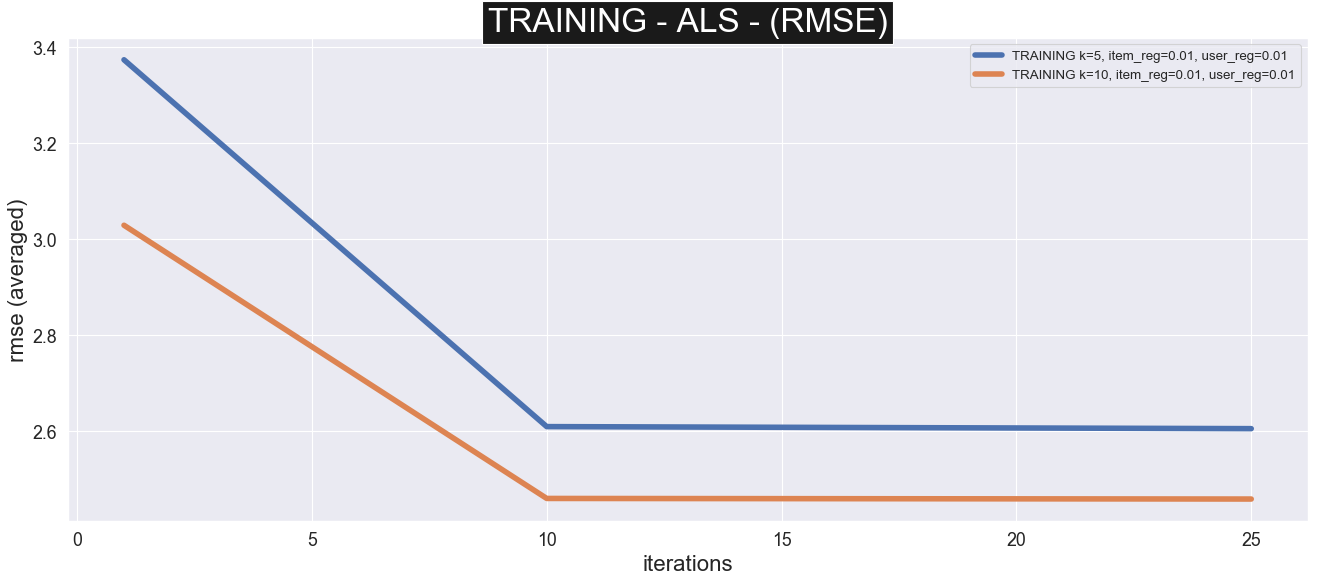

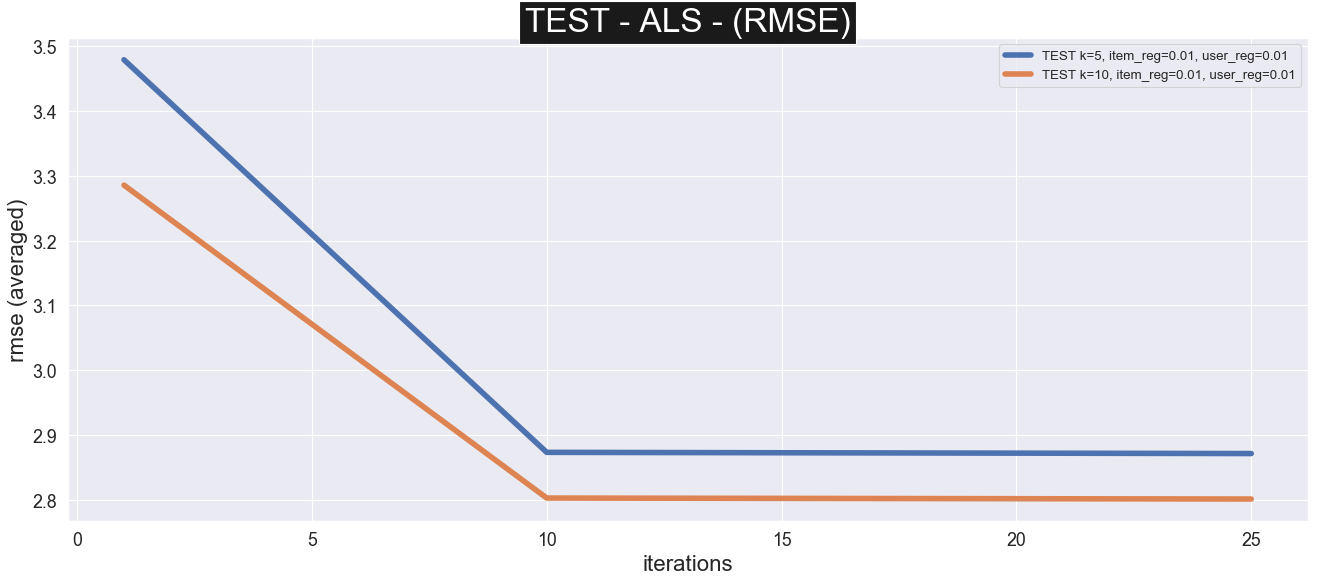

In [46]:
error_method = 'rmse'
field_names = [TRAINING_STRING + error_method, TEST_STRING + error_method]
print(field_names[1])

plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method=error_method, mse_extractor=lambda model: model[field_names[0]], model_type="als", predictions=als_averages_result)
plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method=error_method, mse_extractor=lambda model: model[field_names[1]], model_type="als", predictions=als_averages_result)

In [47]:
error_method = 'mrr'
field_names = [TRAINING_STRING + error_method, TEST_STRING + error_method]

# plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method = error_method, mse_extractor=lambda model: model[field_names[0]], model_type="sgd", predictions=sgd_averages_result_rmse)
# plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method = error_method, mse_extractor=lambda model: model[field_names[1]], model_type="sgd", predictions=sgd_averages_result_rmse)

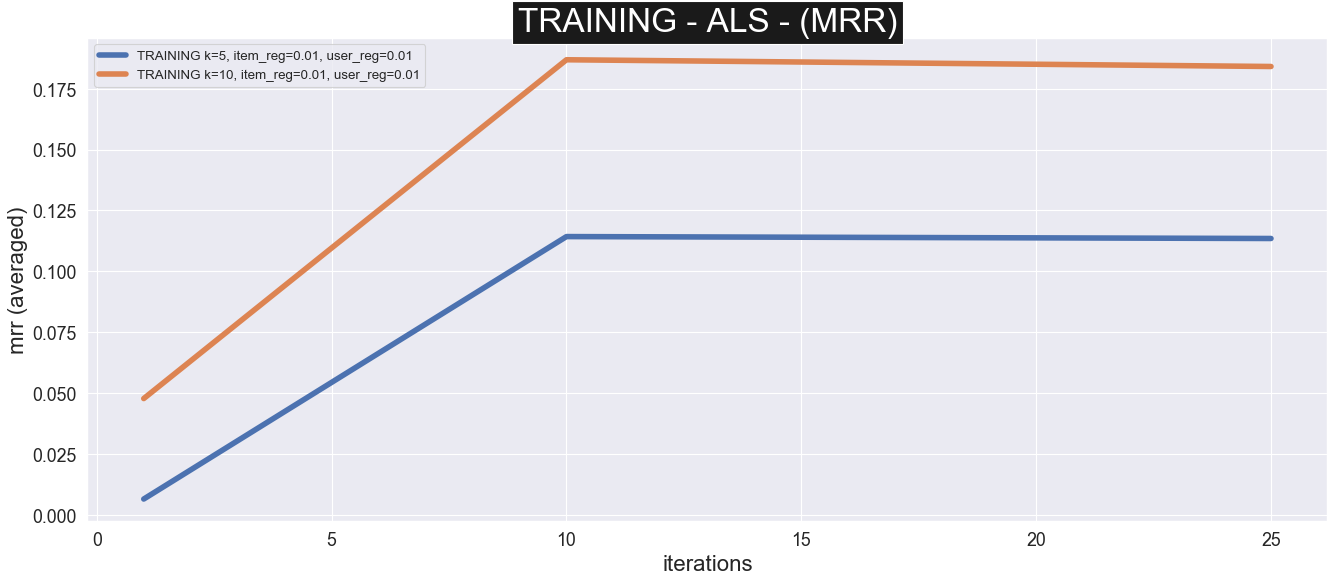

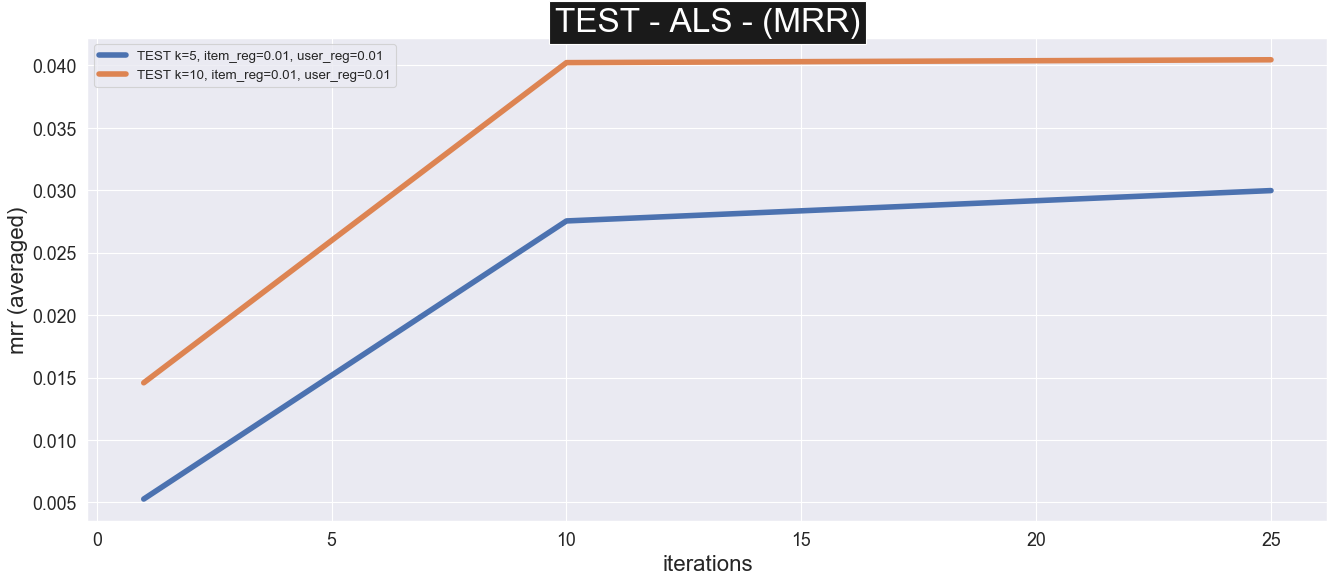

In [48]:
error_method = 'mrr'
field_names = [TRAINING_STRING + error_method, TEST_STRING + error_method]

plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method=error_method, mse_extractor=lambda model: model[field_names[0]], model_type="als", predictions=als_averages_result)
plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method=error_method, mse_extractor=lambda model: model[field_names[1]], model_type="als", predictions=als_averages_result)

In [32]:
error_method = 'ndcg'
field_names = [TRAINING_STRING + error_method, TEST_STRING + error_method]

# plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method = error_method, mse_extractor=lambda model: model[field_names[0]], model_type="sgd", predictions=sgd_averages_result_rmse)
# plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method = error_method, mse_extractor=lambda model: model[field_names[1]], model_type="sgd", predictions=sgd_averages_result_rmse)

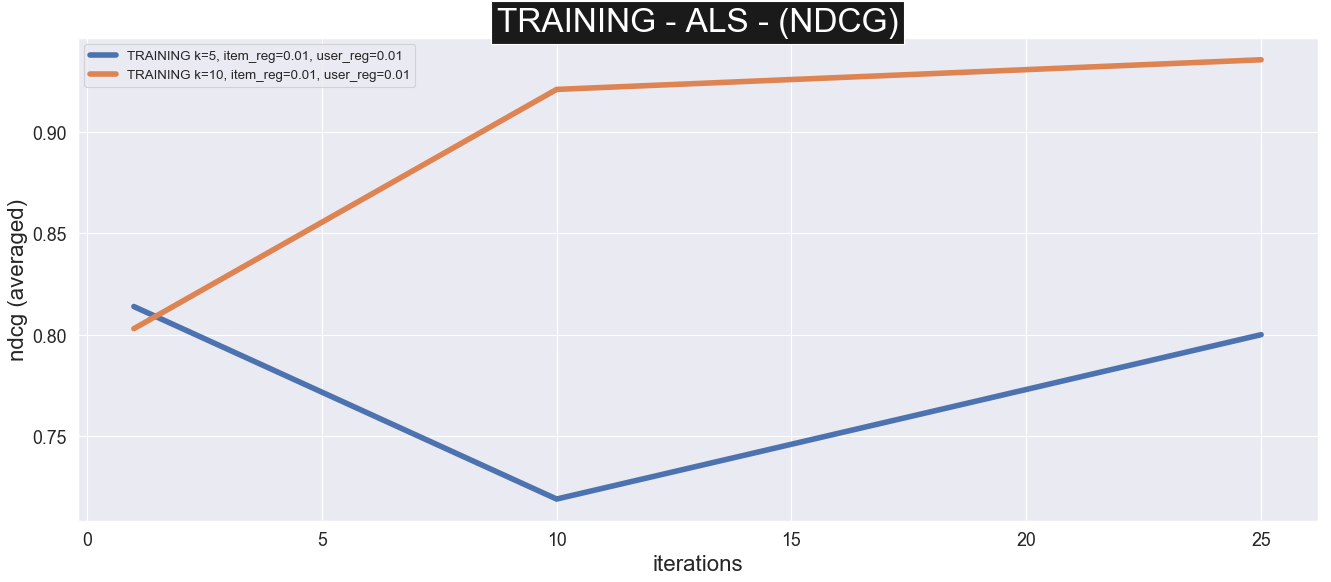

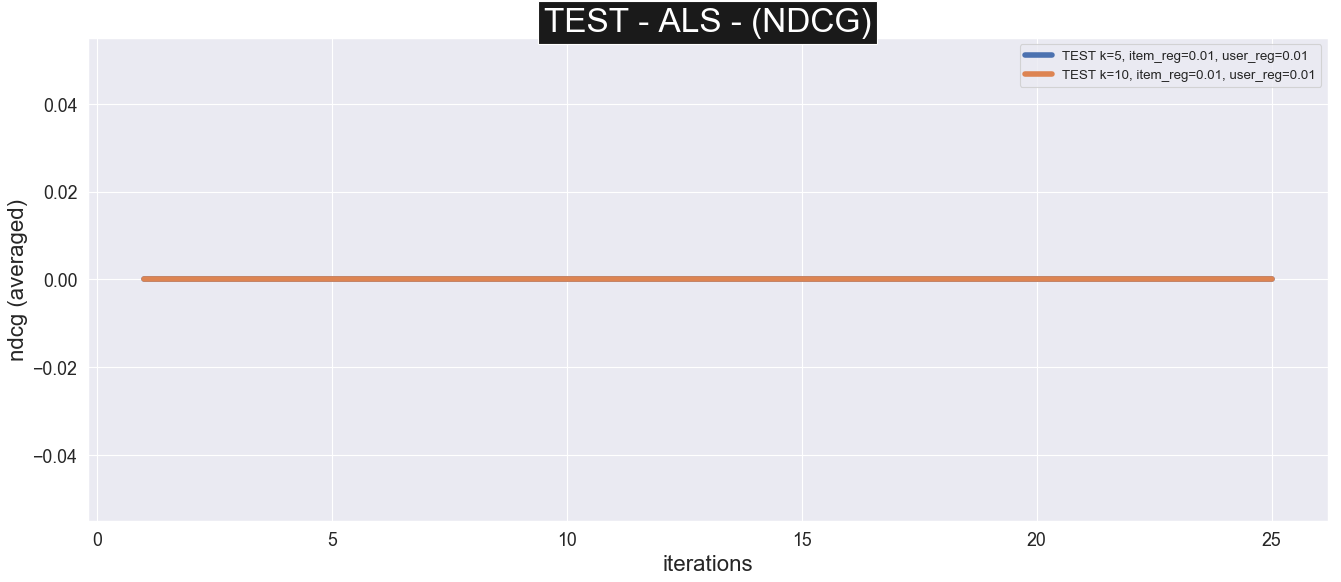

In [33]:
error_method = 'ndcg'
field_names = [TRAINING_STRING + error_method, TEST_STRING + error_method]

plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method=error_method, mse_extractor=lambda model: model[field_names[0]], model_type="als", predictions=als_averages_result)
plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method=error_method, mse_extractor=lambda model: model[field_names[1]], model_type="als", predictions=als_averages_result)

### Question 3: Matrix factorization – item similarity and model explainability (25 points)

#### Answer: